Churn prevention allows companies to develop loyalty programs and retention campaigns to keep as many customers as possible.

In this example, we use customer data from a bank to construct a predictive model for the likely churn clients.

The variable to be predicted is binary (churn or loyal). Therefore this is a classification project.

The goal here is to model churn probability, conditioned on the customer features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore")

# Import data

data is from a modelling competition and it contain sensitive data

In [3]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x116,x117,x118,x119,x120,x121,x122,x123,x124,y
0,0.067563,-2.172492,-1.713774,-0.146854,-0.685219,-0.933838,4.0,2.0,-4.476051,-1.472306,...,4.607926,52.0,1.0,0.773809,0.766531,6.307142,9.074515,-2.694049,0.330964,0
1,0.099622,0.584803,-6.089758,-0.252186,-0.334912,-4.671281,4.0,2.0,-0.387076,-0.664552,...,15.889763,53.0,1.0,7.065852,0.994304,-0.028411,-21.472850,5.626095,1.293455,0
2,0.648421,3.881137,0.961359,0.217361,-1.471850,-0.975352,5.0,1.0,-0.850146,-4.011487,...,13.770410,53.0,1.0,-8.598553,-2.958302,-12.784030,-36.855873,0.356093,1.499790,0
3,0.005775,-2.726153,2.891378,-0.038325,2.280847,1.761478,3.0,3.0,9.116188,-4.610151,...,5.904901,50.0,1.0,8.194975,-7.798308,10.910515,15.226094,-10.440813,-0.735116,0
4,0.044396,2.803576,-1.923381,-0.116657,-1.574199,6.098627,3.0,1.0,-13.956141,13.785099,...,-14.603703,47.0,0.0,2.330789,-8.249825,-12.680490,40.192302,-5.037065,1.679262,1


In [4]:
df_test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x116,x117,x118,x119,x120,x121,x122,x123,x124,y
0,0.403735,-1.966104,-1.322339,0.084642,2.481997,-1.719155,5.0,2.0,-11.546670,-7.073770,...,-7.765934,59.0,1.0,-9.897690,5.694125,-6.734618,17.052251,3.601040,2.873498,0
1,0.032128,6.516294,-0.939752,0.026937,-0.992999,5.995462,4.0,3.0,-5.634876,1.937998,...,15.667015,47.0,1.0,7.781887,9.752716,5.918369,15.922908,5.460557,10.475816,0
2,-0.280345,0.930291,-1.028828,-0.050924,-3.164733,6.885108,3.0,2.0,1.609005,-1.812488,...,8.523648,55.0,0.0,6.815214,-3.325532,4.123546,-19.656038,8.380318,-1.203315,0
3,-0.313420,-0.568857,-1.576051,-0.003607,5.539969,-1.594770,4.0,3.0,-11.517734,-5.364282,...,-13.912115,41.0,0.0,3.158137,-7.088875,-3.035983,34.277048,-3.169203,1.417681,0
4,0.108825,-4.815631,5.491084,-0.123928,-1.932024,4.014821,5.0,3.0,-3.117576,2.004889,...,-14.432712,52.0,0.0,-3.867657,-13.308519,1.008302,41.449381,-0.804560,-0.649453,0


# EDA

In [22]:
df_train.groupby('x21').agg({"x0":(np.nanmean,np.nanstd),"x1":np.nanmean})

x0                  x1
      nanmean    nanstd   nanmean
x21                              
Apr -0.004327  0.421969 -0.000844
Aug  0.003092  0.424122  0.045679
Dec -0.163770  0.390685  0.907038
Feb -0.040469  0.412641 -0.053096
Jan  0.036535  0.319520  0.751807
Jul  0.000136  0.423281 -0.007223
Jun  0.001005  0.425301  0.003522
Mar  0.004019  0.428786 -0.218786
May -0.002314  0.423925  0.014539
Nov  0.025535  0.392620  0.158384
Oct  0.011870  0.432944 -0.049502
Sep -0.003915  0.428036 -0.076729

In [10]:
df_train.dtypes

x0      float64
x1      float64
x2      float64
x3      float64
x4      float64
         ...   
x121    float64
x122    float64
x123    float64
x124    float64
y         int64
Length: 126, dtype: object

In [ ]:
null_val_sums = df_train.isnull().sum()
pd.set_option("display.max_rows", None)
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df_train) })

,Column,Number of Null Values,Proportion
0,x0,123,0.00123
1,x1,131,0.00131
2,x2,124,0.00124
3,x3,115,0.00115
4,x4,137,0.00137
5,x5,116,0.00116
6,x6,122,0.00122
7,x7,133,0.00133
8,x8,134,0.00134
9,x9,130,0.00130


In [ ]:
null_val_sums = df_test.isnull().sum()
pd.set_option("display.max_rows", None)
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df_test) })

,Column,Number of Null Values,Proportion
0,x0,40,0.00160
1,x1,30,0.00120
2,x2,26,0.00104
3,x3,27,0.00108
4,x4,39,0.00156
5,x5,36,0.00144
6,x6,36,0.00144
7,x7,31,0.00124
8,x8,32,0.00128
9,x9,38,0.00152


Proportion : 0.16992


<AxesSubplot:xlabel='y', ylabel='count'>

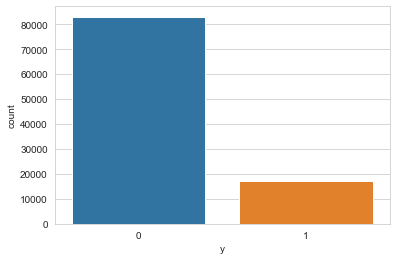

In [ ]:
print("Proportion : {}".format(df_train["y"].sum() / len(df_train)))
sns.countplot(x='y', data=df_train)


In [ ]:
categorical = df_train.columns[(df_train.dtypes.values != np.dtype('float64'))]

In [ ]:
categorical

Index(['x21', 'x79', 'x89', 'x108', 'x112', 'y'], dtype='object')

In [ ]:
numerical = df_train.columns[(df_train.dtypes.values == np.dtype('float64'))]

In [ ]:
numerical

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123',
       'x124'],
      dtype='object', length=120)

In [ ]:
target_0 = df_train[df_train['y'] == 0]
target_1 = df_train[df_train['y'] == 1]



In [ ]:
num_nonfloat = np.array(['x6','x7','x22','x51','x63','x80','x93','x96','x104','x117','x118']).astype('object')

In [ ]:
num_nonfloat

array(['x6', 'x7', 'x22', 'x51', 'x63', 'x80', 'x93', 'x96', 'x104',
       'x117', 'x118'], dtype=object)

In [ ]:
indx = np.ravel([np.where(numerical == i) for i in num_nonfloat])
numerical=np.delete(numerical,indx)

In [ ]:
numerical

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x8', 'x9', 'x10', 'x11',
       ...
       'x113', 'x114', 'x115', 'x116', 'x119', 'x120', 'x121', 'x122', 'x123',
       'x124'],
      dtype='object', length=109)

## Categorical Data

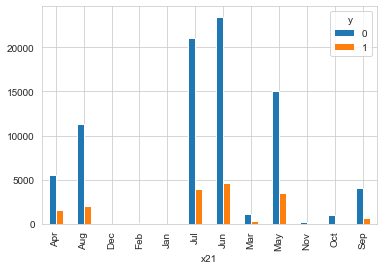

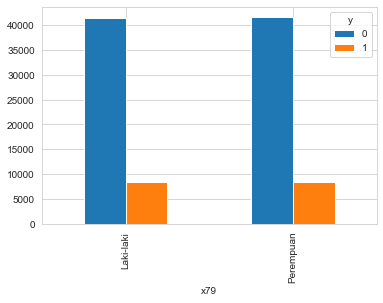

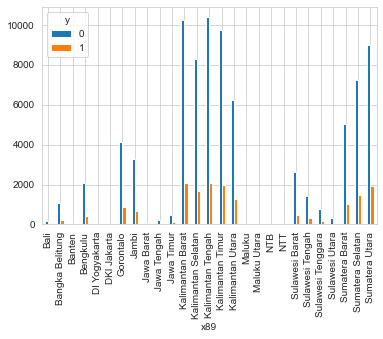

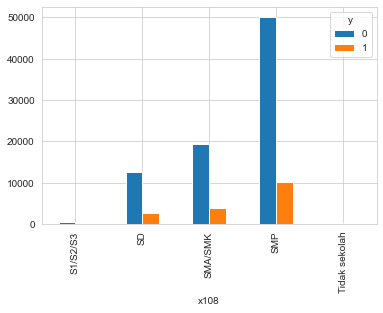

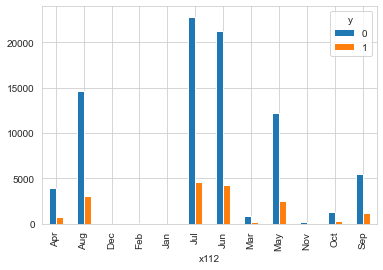

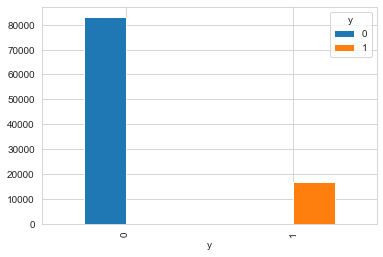

In [ ]:
for i in categorical:
    pd.crosstab(df_train[i],df_train['y']).plot(kind="bar")

In [ ]:
for x in categorical:
    print(df_train[x].value_counts(),'\n')

Jun    28155
Jul    25018
May    18494
Aug    13334
Apr     7046
Sep     4738
Mar     1495
Oct     1160
Nov      197
Feb      183
Jan       27
Dec       27
Name: x21, dtype: int64 

Perempuan    50046
Laki-laki    49836
Name: x79, dtype: int64 

Kalimantan Tengah     12449
Kalimantan Barat      12343
Kalimantan Timur      11678
Sumatera Utara        10943
Kalimantan Selatan     9921
Sumatera Selatan       8715
Kalimantan Utara       7519
Sumatera Barat         6086
Gorontalo              4991
Jambi                  3926
Sulawesi Barat         3099
Bengkulu               2465
Sulawesi Tengah        1757
Bangka Belitung        1313
Sulawesi Tenggara       929
Jawa Timur              592
Sulawesi Utara          404
Jawa Tengah             284
Bali                    183
Jawa Barat              121
NTB                      61
DI Yogyakarta            41
NTT                      26
Banten                   11
Maluku                    9
Maluku Utara              6
DKI Jakarta               

In [ ]:
# for x in categorical:
#     df_train[x]=df_train[x].fillna(df_train[x].mode()[0],inplace=True)

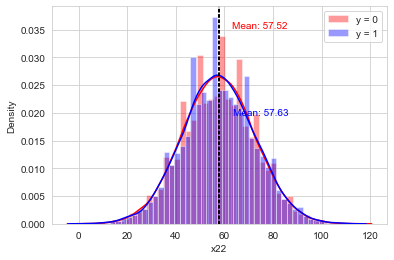

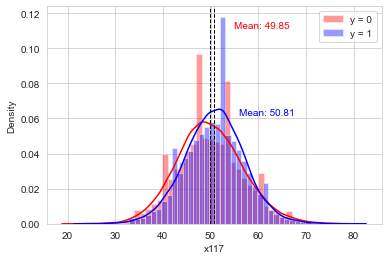

In [ ]:
temp = ['x22','x117']
for x in temp:
    sns.distplot(target_0[x],color='red',label='y = 0')
    sns.distplot(target_1[x],color='blue',label = 'y = 1')
    plt.legend(loc="upper right")
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(target_0[x].mean(), color='k', linestyle='dashed', linewidth=1)
    plt.text(target_0[x].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(target_0[x].mean()),color='red')
    plt.axvline(target_1[x].mean(), color='k', linestyle='dashed', linewidth=1)
    plt.text(target_1[x].mean()*1.1, max_ylim*0.5, 'Mean: {:.2f}'.format(target_1[x].mean()),color= 'blue')
    plt.legend(loc="upper right")
    plt.show()

## Non-Float Numerical Data

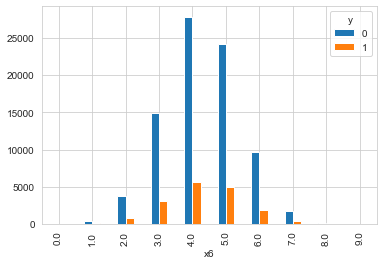

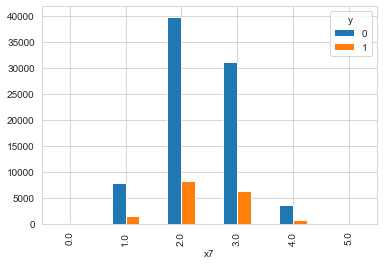

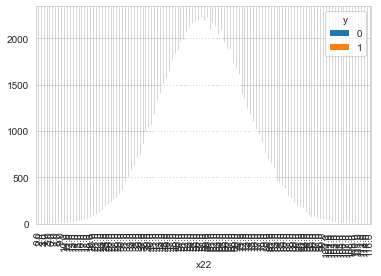

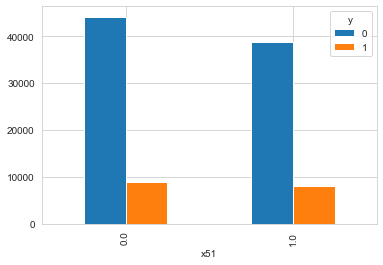

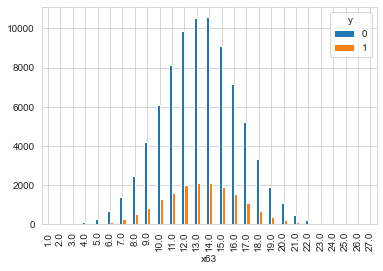

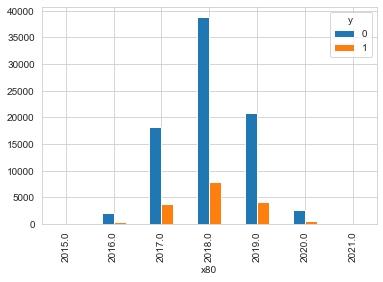

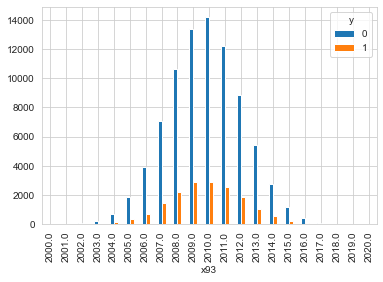

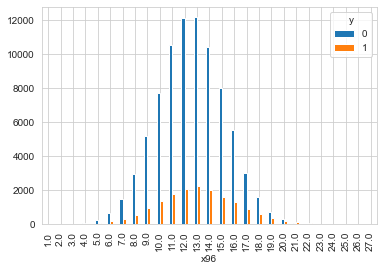

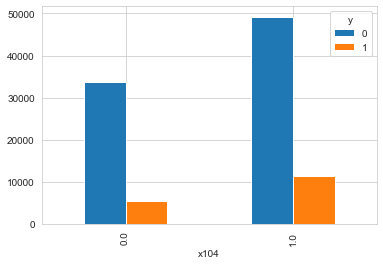

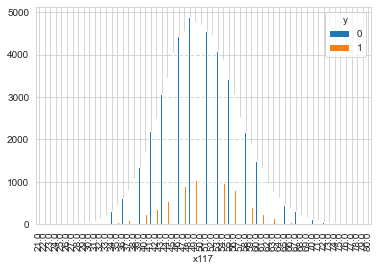

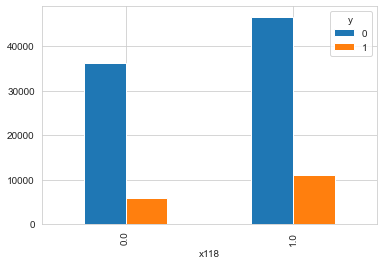

In [ ]:
for i in num_nonfloat:
    pd.crosstab(df_train[i],df_train['y']).plot(kind="bar")

In [ ]:
# for x in num_nonfloat:
#     print(x,(df_train[x].median()))
#     df_train[x].fillna(df_train[x].mode()[0],inplace=True)


## Float Numerical Data

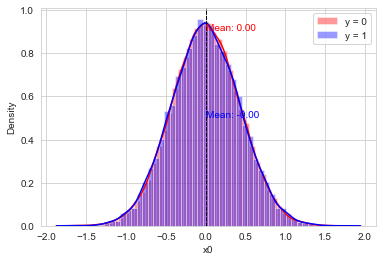

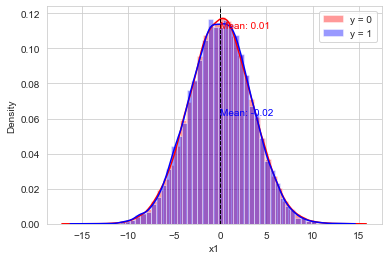

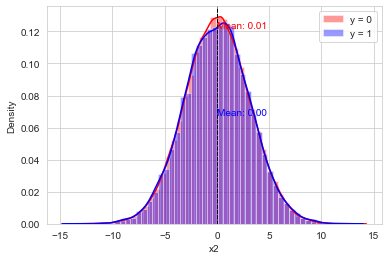

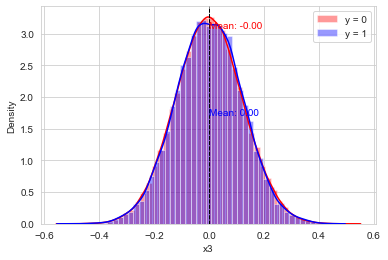

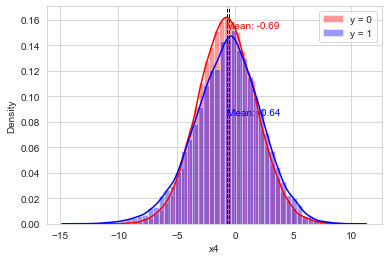

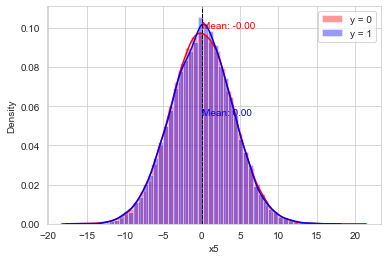

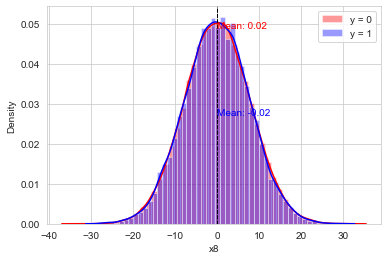

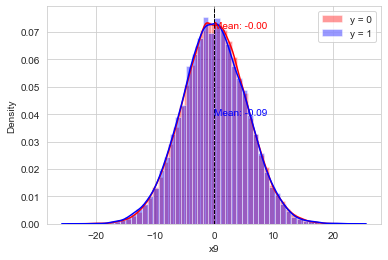

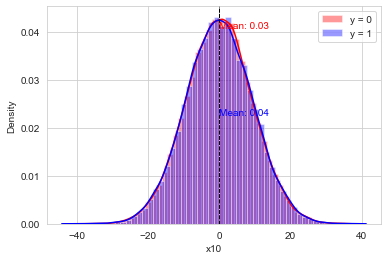

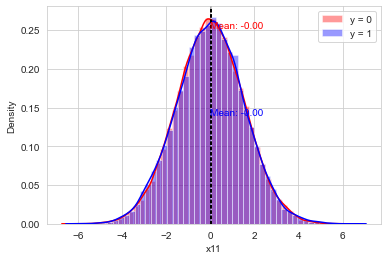

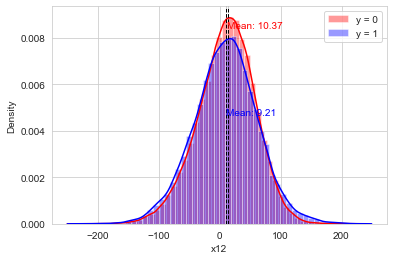

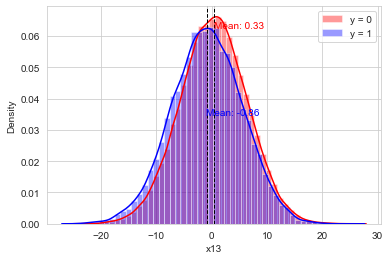

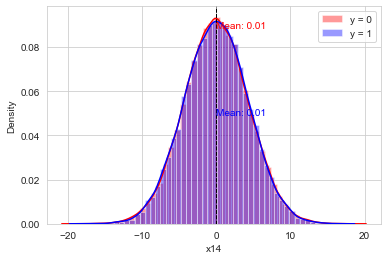

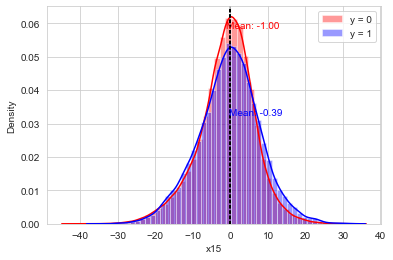

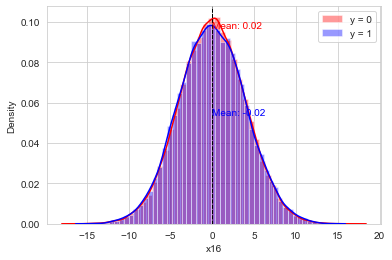

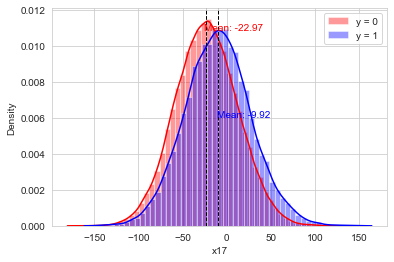

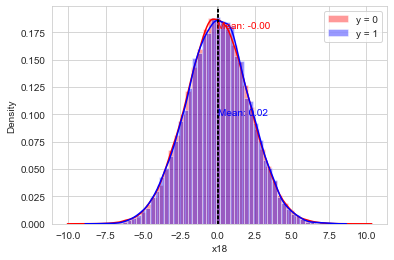

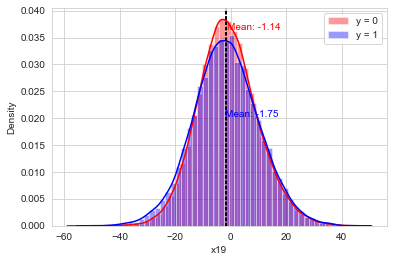

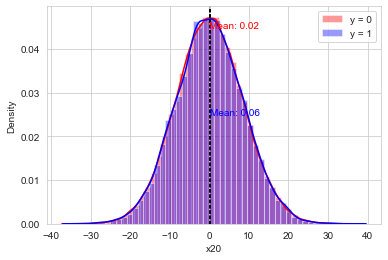

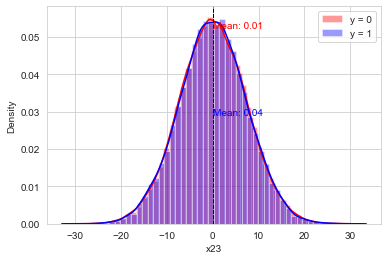

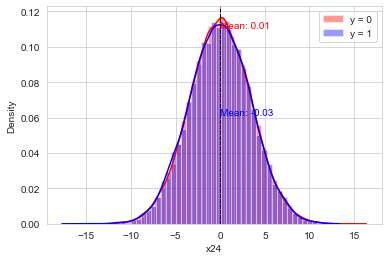

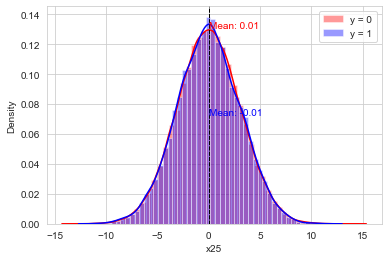

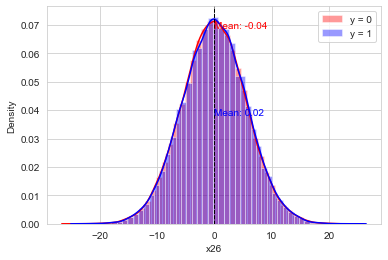

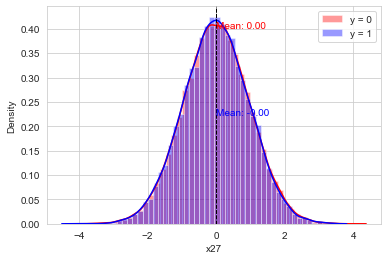

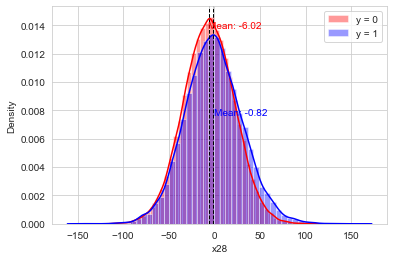

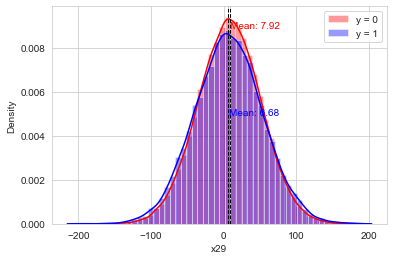

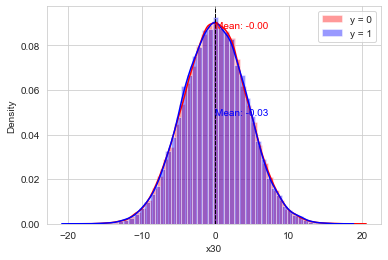

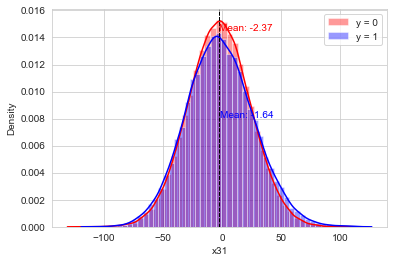

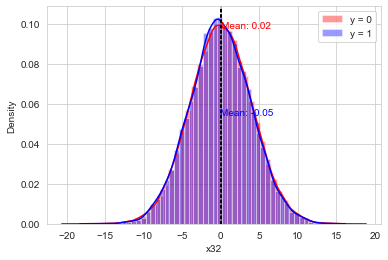

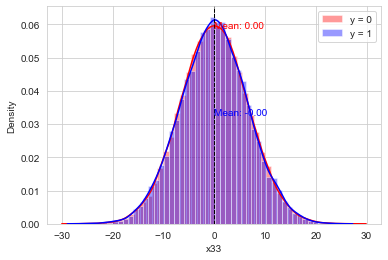

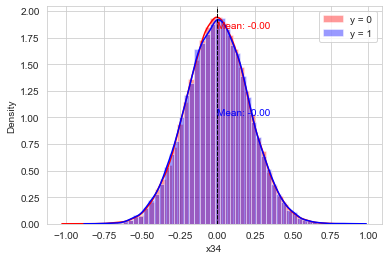

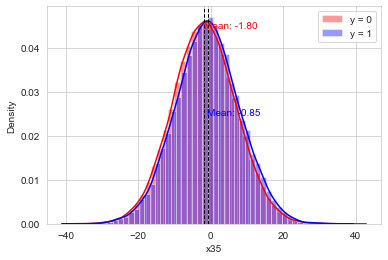

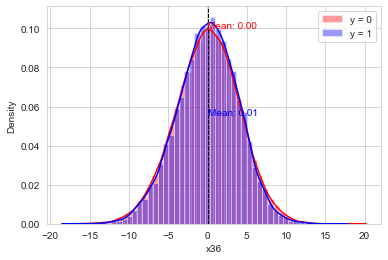

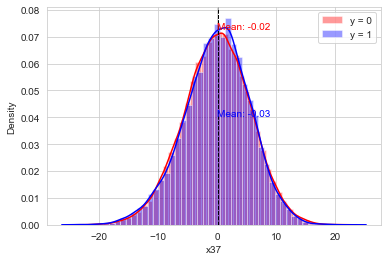

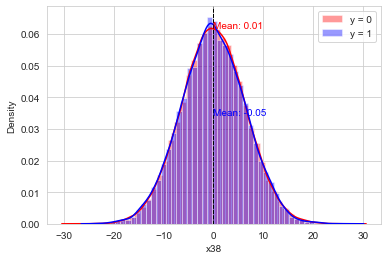

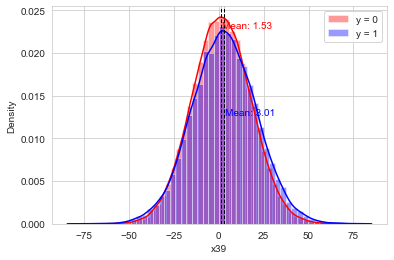

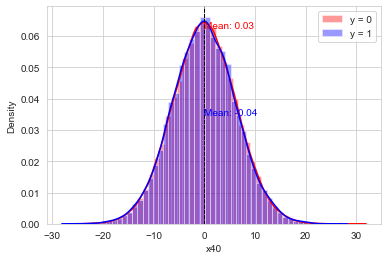

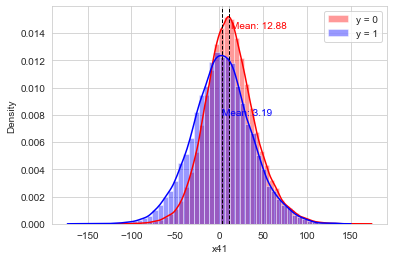

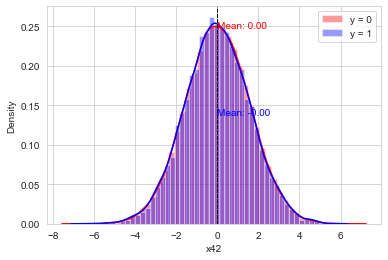

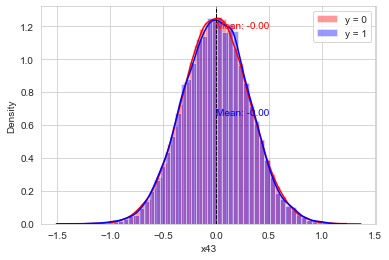

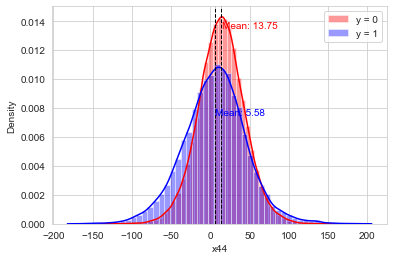

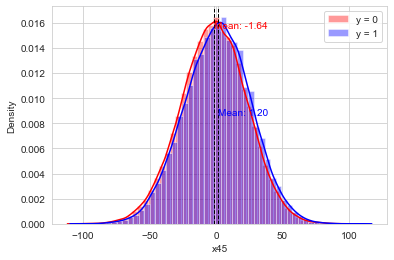

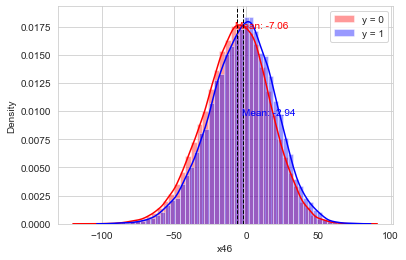

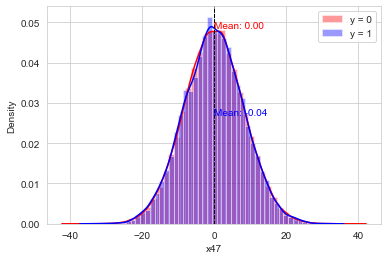

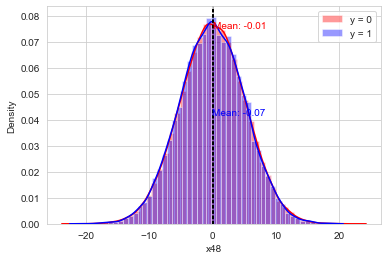

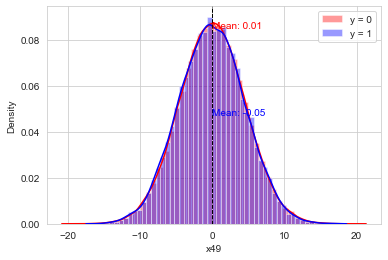

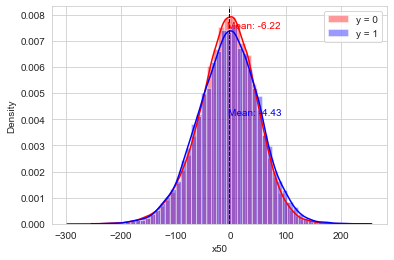

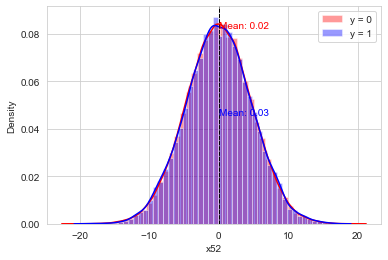

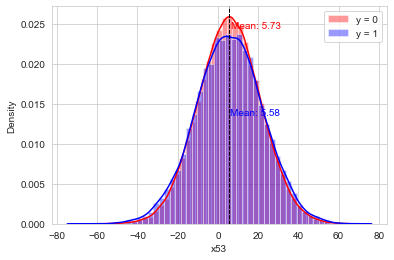

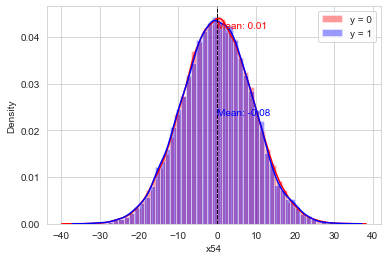

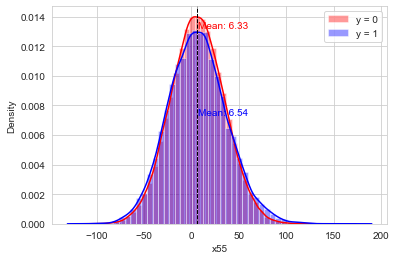

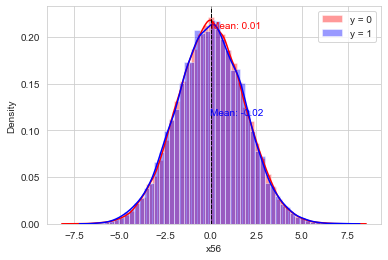

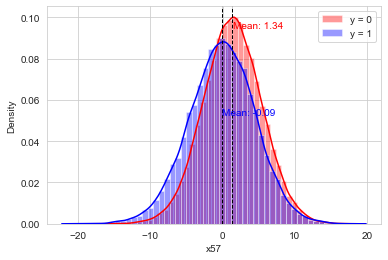

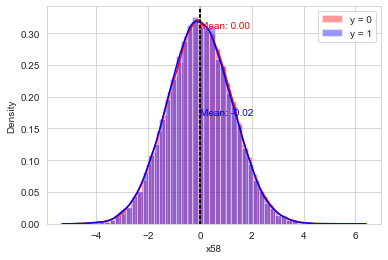

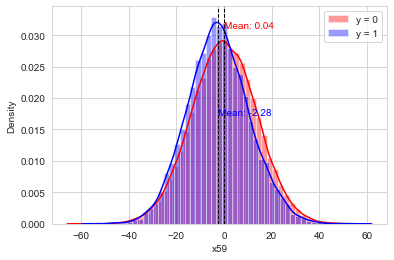

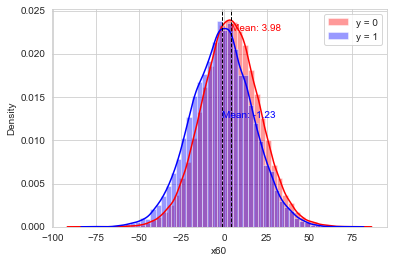

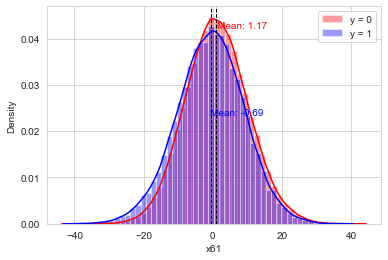

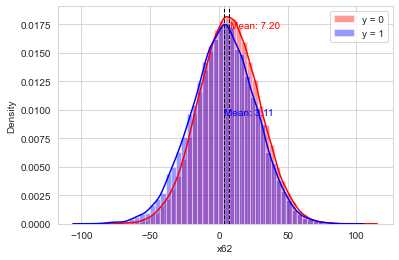

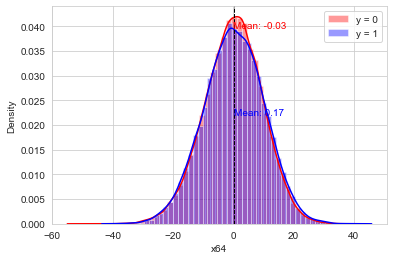

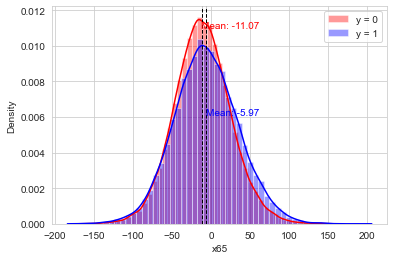

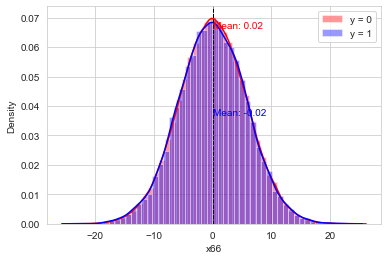

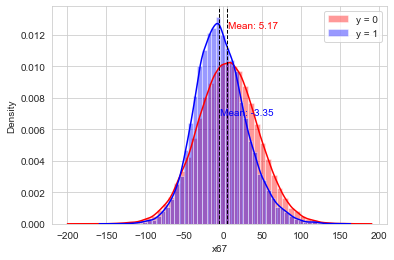

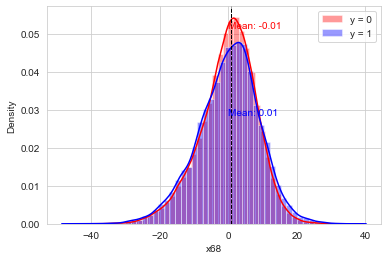

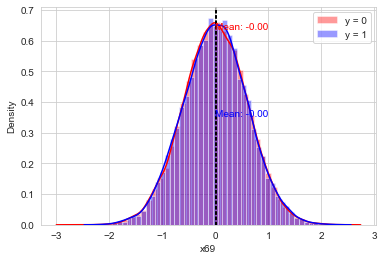

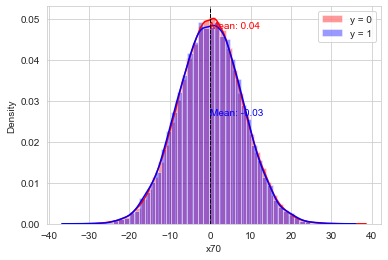

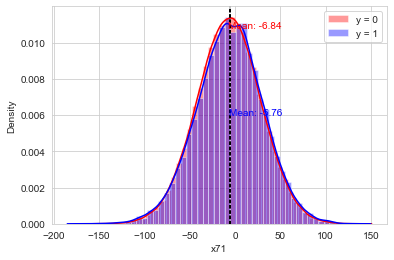

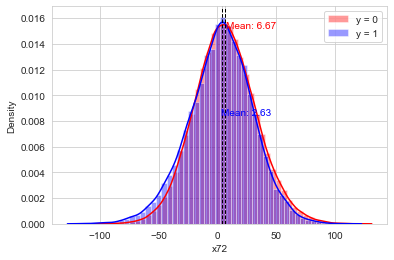

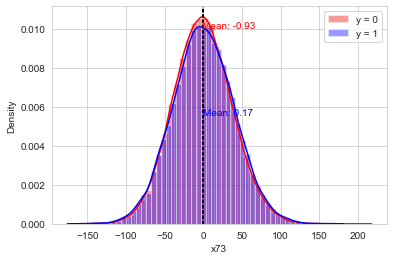

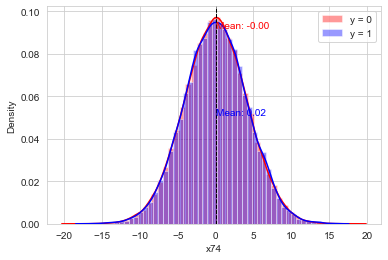

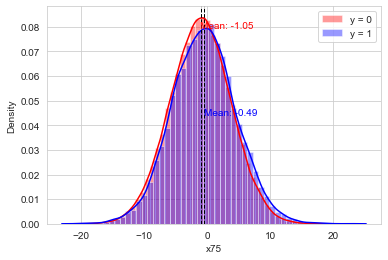

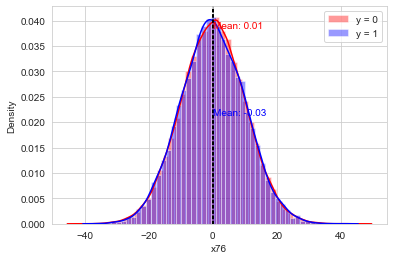

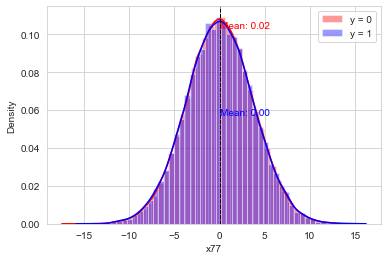

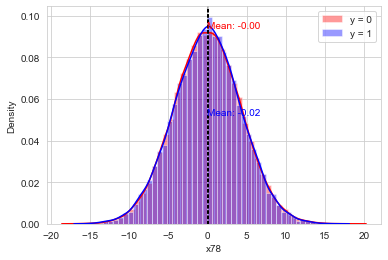

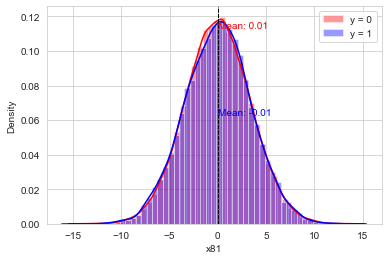

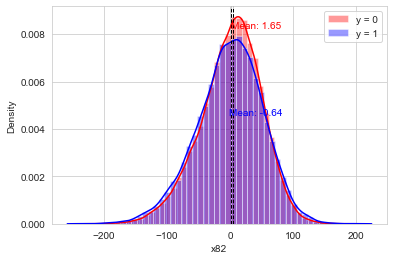

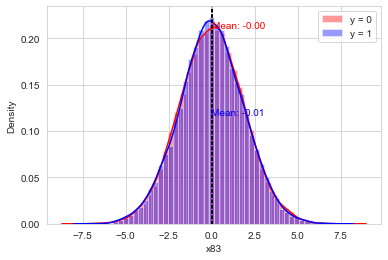

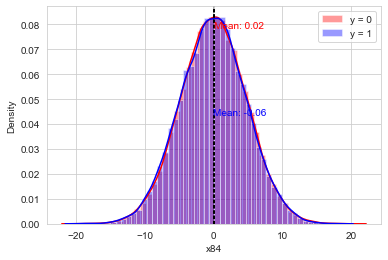

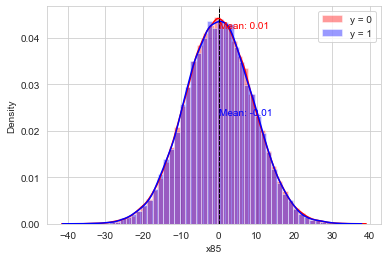

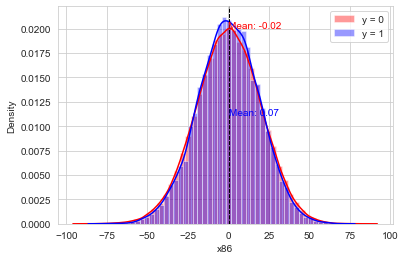

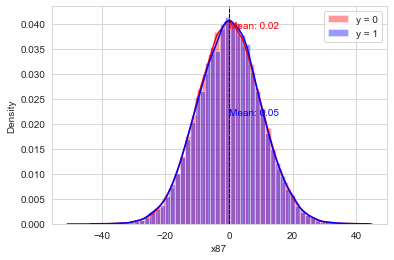

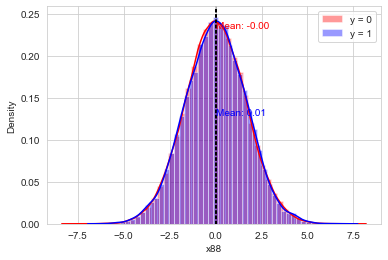

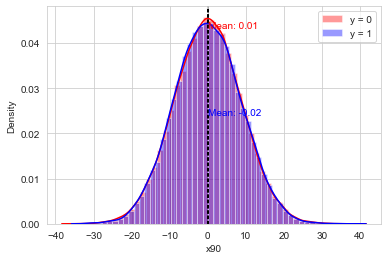

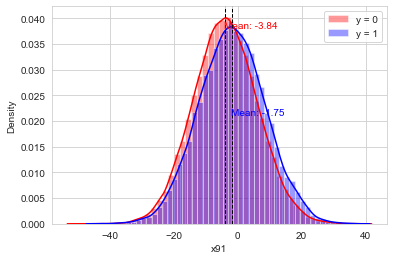

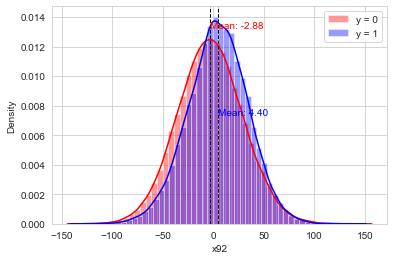

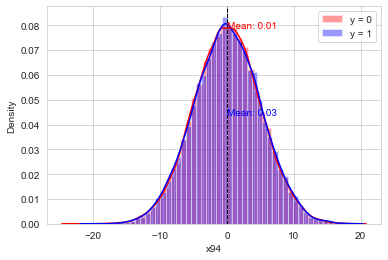

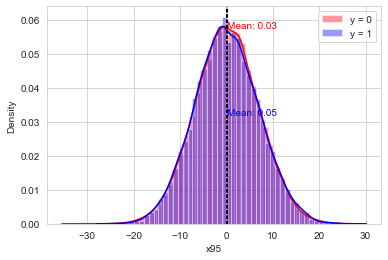

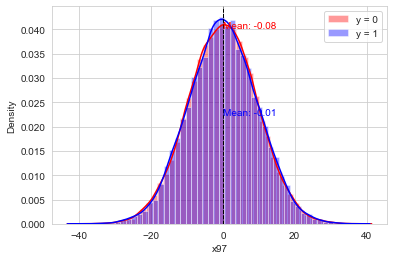

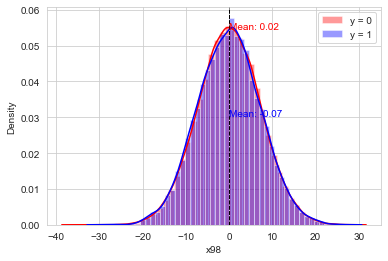

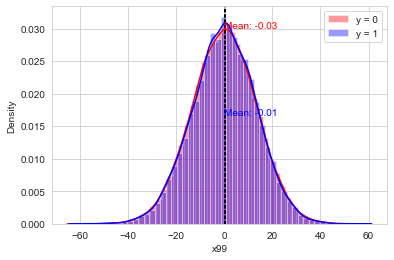

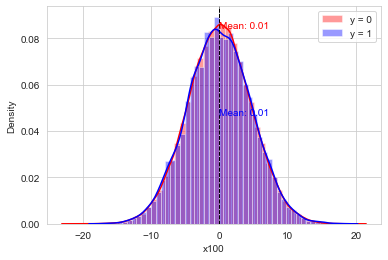

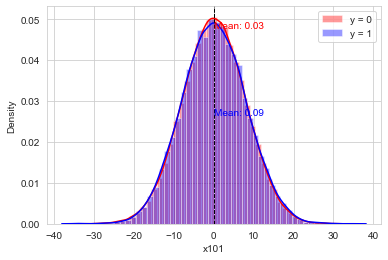

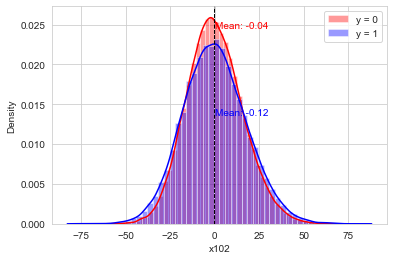

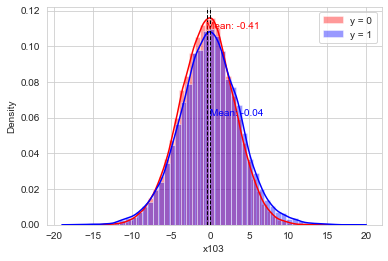

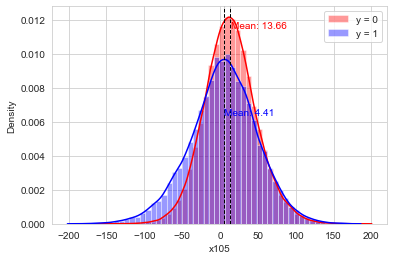

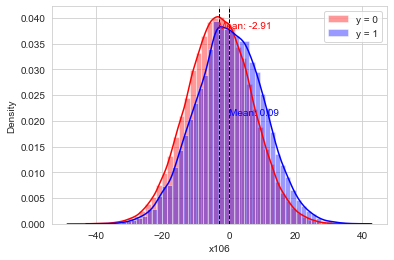

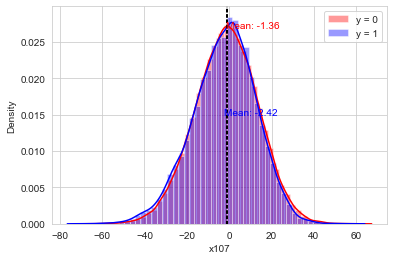

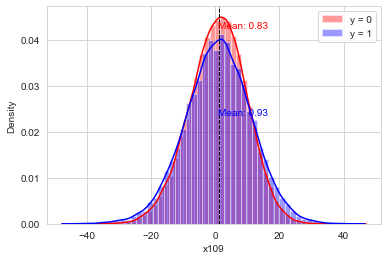

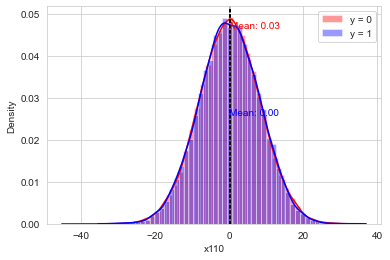

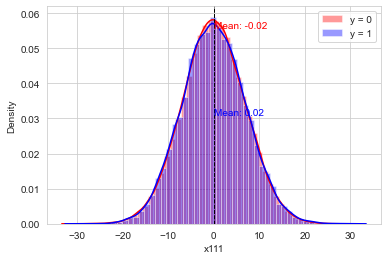

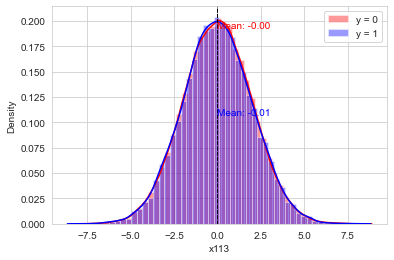

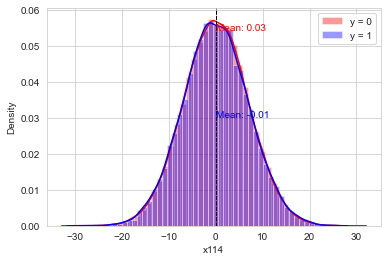

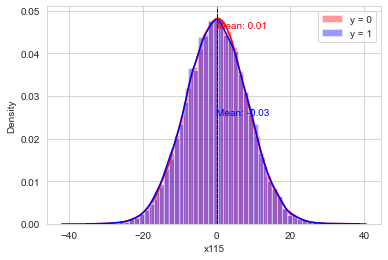

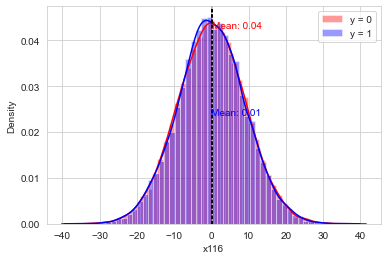

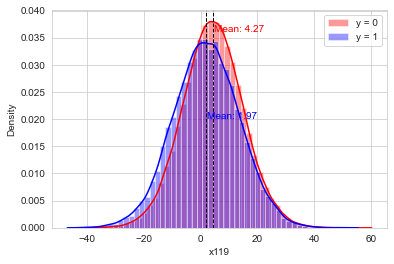

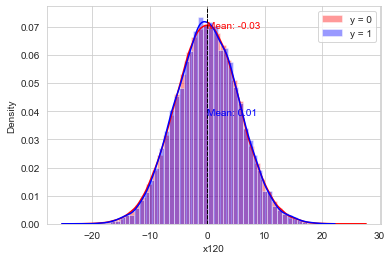

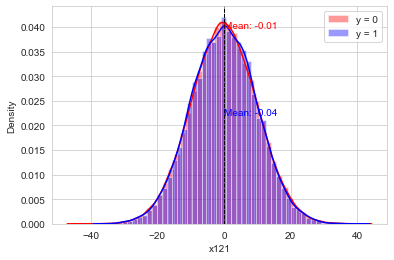

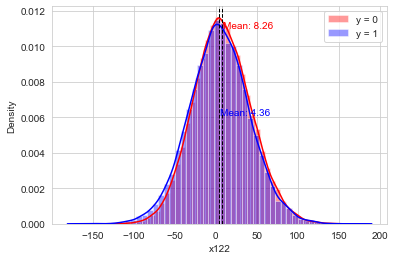

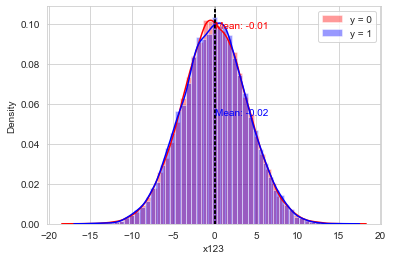

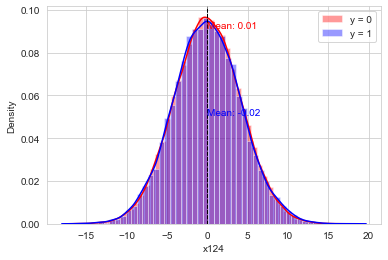

In [ ]:
for x in numerical:
    sns.distplot(target_0[x],color='red',label='y = 0')
    sns.distplot(target_1[x],color='blue',label = 'y = 1')
    plt.legend(loc="upper right")
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(target_0[x].median(), color='k', linestyle='dashed', linewidth=1)
    plt.text(target_0[x].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(target_0[x].mean()),color='red')
    plt.axvline(target_1[x].median(), color='k', linestyle='dashed', linewidth=1)
    plt.text(target_1[x].mean()*1.1, max_ylim*0.5, 'Mean: {:.2f}'.format(target_1[x].mean()),color= 'blue')
    plt.legend(loc="upper right")
    plt.show()

# Feature Engineering

## Impute Missing Value

Fill Missing Value Numerical Float with median

In [ ]:
for x in numerical:
    df_train[x]=df_train[x].fillna(df_train[x].median())

In [ ]:
null_val_sums = df_train[numerical].isnull().sum()
pd.set_option("display.max_rows", None)
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df_train[numerical]) })

Fill Missing value of Categorical and Numerical Non-float with Mode

In [ ]:
for x in num_nonfloat:
    df_train[x] = df_train[x].fillna(df_train[x].mode()[0])

In [ ]:
for x in categorical:
    df_train[x] = df_train[x].fillna(df_train[x].mode()[0])

In [ ]:
null_val_sums = df_train[num_nonfloat].isnull().sum()
pd.set_option("display.max_rows", None)
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df_train[num_nonfloat]) })

## Train-Test Split

In [ ]:
X = df_train.drop(labels=['y'],axis=1)
y = df_train['y']

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_rescaled = scaler.fit_transform(X[numerical])

Text(0, 0.5, 'cumulative explained variance')

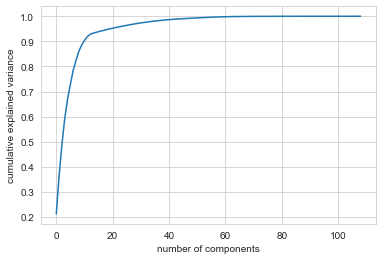

In [ ]:
pca = PCA().fit(X[numerical])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
pca.components_.shape

(109, 109)

In [ ]:
cumvar = pd.DataFrame({'number of components': np.arange(1,109), 'explained variance ratio': np.cumsum(pca.explained_variance_ratio_)[1:]})
cumvar

,number of components,explained variance ratio
0,1,0.364404
1,2,0.488584
2,3,0.592564
3,4,0.669153
4,5,0.728714
5,6,0.784688
6,7,0.823808
7,8,0.860424
8,9,0.884802
9,10,0.903824


In [ ]:
pca = PCA(n_components=35)
X_pca = pca.fit_transform(X[numerical])
# X_pca = pca.fit_transform(X_rescaled)
X_pca

array([[-1.64268682e+02, -1.04438239e+02,  4.59682238e+01, ...,
         1.09938465e+01,  1.25721029e+00,  4.58807968e+00],
       [ 7.27039442e+00,  1.08822932e+02, -2.30076889e+01, ...,
        -1.26302879e+01,  5.77186940e+00,  1.48875616e-01],
       [ 4.55537436e+01,  5.65109359e+01,  9.44267842e+00, ...,
        -2.42999265e+00, -7.03701477e+00,  1.04431395e+01],
       ...,
       [ 1.93014348e+01,  9.30277271e+01, -1.19168253e+01, ...,
        -7.72512322e+00,  6.91804826e+00, -4.64325547e+00],
       [ 1.46344371e+02, -1.64285820e+01,  1.93221209e+01, ...,
        -8.02272425e+00,  8.03698208e+00, -1.79963717e+00],
       [ 4.00557034e+01,  8.90352776e+00,  3.74679064e+01, ...,
         7.74476468e+00,  1.16819075e+01,  5.72355186e+00]])

In [ ]:
nCol =np.arange(1,len(X_pca[1,:])+1)

In [ ]:
col = []
for x in nCol:
    col.append('PC'+str(x))

In [ ]:
X_pca_ = pd.DataFrame(data=X_pca,columns=col)


In [ ]:
X_pca_.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,-164.268682,-104.438239,45.968224,52.386545,-24.668651,-2.737207,-7.430159,5.507118,-30.563076,-24.782297,...,9.883421,1.101969,-4.131897,-13.544494,5.238216,-13.518549,-8.419799,10.993846,1.257210,4.588080
1,7.270394,108.822932,-23.007689,-38.846633,-61.640356,-12.437926,61.213488,-6.071308,36.145302,18.424439,...,2.625201,0.496454,5.804877,-8.400150,1.988566,-6.568501,16.754622,-12.630288,5.771869,0.148876
2,45.553744,56.510936,9.442678,25.585912,11.716666,-43.753559,34.889391,-69.304049,29.532260,-10.061750,...,-7.613603,-9.886747,3.245679,-0.760250,0.957948,1.187809,-4.051917,-2.429993,-7.037015,10.443139
3,-94.974498,103.865795,-1.509163,-49.961214,-38.530131,18.658034,-0.689781,68.761952,-13.524689,8.339692,...,14.636392,-3.947157,-3.055871,-3.878996,-8.006345,-0.237331,0.914040,5.209097,4.532410,-1.561758
4,-28.369577,14.561770,70.761514,-10.352005,-35.642255,-13.865466,-97.641113,11.041376,-19.116691,-3.894344,...,-4.758498,1.717397,2.816929,5.381668,14.067176,-0.710463,10.976279,-11.224621,-26.669710,1.034777


## One hot Encoding

In [ ]:
X[categorical].head()

,x21,x79,x89,x108,x112
0,Jun,Laki-laki,Jambi,SMP,May
1,Jul,Perempuan,Sumatera Barat,SMP,May
2,Jul,Perempuan,Sumatera Selatan,SD,Jun
3,Jun,Laki-laki,Kalimantan Utara,SMP,Sep
4,Jul,Laki-laki,Kalimantan Utara,SMA/SMK,Jun


In [ ]:
X_cat = X[categorical]

In [ ]:
for i in categorical:
    X_cat = pd.get_dummies(X_cat, columns=[i])

In [ ]:
X_cat.head()

,x21_Apr,x21_Aug,x21_Dec,x21_Feb,x21_Jan,x21_Jul,x21_Jun,x21_Mar,x21_May,x21_Nov,...,x112_Dec,x112_Feb,x112_Jan,x112_Jul,x112_Jun,x112_Mar,x112_May,x112_Nov,x112_Oct,x112_Sep
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
X_nonfloat = X[num_nonfloat]

In [ ]:
X_new = pd.concat([X_pca_,X_cat,X_nonfloat], axis=1)

In [ ]:
X_new = X_new.drop(labels=['x79_Perempuan'],axis=1)

In [ ]:
null_val_sums = X_new.isnull().sum()
pd.set_option("display.max_rows", None)
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(X_new) })

,Column,Number of Null Values,Proportion
0,PC1,0,0.0
1,PC2,0,0.0
2,PC3,0,0.0
3,PC4,0,0.0
4,PC5,0,0.0
5,PC6,0,0.0
6,PC7,0,0.0
7,PC8,0,0.0
8,PC9,0,0.0
9,PC10,0,0.0


In [ ]:
X_new.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,x7,x22,x51,x63,x80,x93,x96,x104,x117,x118
0,-164.268682,-104.438239,45.968224,52.386545,-24.668651,-2.737207,-7.430159,5.507118,-30.563076,-24.782297,...,2.0,52.0,0.0,13.0,2019.0,2010.0,9.0,1.0,52.0,1.0
1,7.270394,108.822932,-23.007689,-38.846633,-61.640356,-12.437926,61.213488,-6.071308,36.145302,18.424439,...,2.0,78.0,0.0,13.0,2018.0,2009.0,14.0,0.0,53.0,1.0
2,45.553744,56.510936,9.442678,25.585912,11.716666,-43.753559,34.889391,-69.304049,29.532260,-10.061750,...,1.0,39.0,0.0,14.0,2019.0,2009.0,16.0,0.0,53.0,1.0
3,-94.974498,103.865795,-1.509163,-49.961214,-38.530131,18.658034,-0.689781,68.761952,-13.524689,8.339692,...,3.0,48.0,0.0,14.0,2018.0,2014.0,10.0,1.0,50.0,1.0
4,-28.369577,14.561770,70.761514,-10.352005,-35.642255,-13.865466,-97.641113,11.041376,-19.116691,-3.894344,...,1.0,50.0,0.0,14.0,2017.0,2011.0,13.0,1.0,47.0,0.0


In [ ]:
X[num_nonfloat].head()

,x6,x7,x22,x51,x63,x80,x93,x96,x104,x117,x118
0,4.0,2.0,52.0,0.0,13.0,2019.0,2010.0,9.0,1.0,52.0,1.0
1,4.0,2.0,78.0,0.0,13.0,2018.0,2009.0,14.0,0.0,53.0,1.0
2,5.0,1.0,39.0,0.0,14.0,2019.0,2009.0,16.0,0.0,53.0,1.0
3,3.0,3.0,48.0,0.0,14.0,2018.0,2014.0,10.0,1.0,50.0,1.0
4,3.0,1.0,50.0,0.0,14.0,2017.0,2011.0,13.0,1.0,47.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((70000, 103), (30000, 103))

## Oversampling

In [ ]:
from imblearn.combine import SMOTEENN
from collections import Counter

print('Before', Counter(y_train))

smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train,y_train)

print('after ',Counter(y_train_smenn))

Before Counter({0: 58185, 1: 11815})
after  Counter({1: 57162, 0: 26090})


## Feature Selection

### VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_smenn.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_smenn.values, i) for i in range(len(X_train_smenn.columns))]
vif_data

,feature,VIF
0,x0,1.002916
1,x1,1.003617
2,x2,1.004175
3,x3,1.003507
4,x4,623.872445
5,x5,1.003461
6,x6,17.581390
7,x7,13.198695
8,x8,1.003526
9,x9,1.004628


In [ ]:
feature = vif_data[vif_data['VIF'] < 5]
feature

,feature,VIF
0,x0,1.002916
1,x1,1.003617
2,x2,1.004175
3,x3,1.003507
5,x5,1.003461
8,x8,1.003526
9,x9,1.004628
10,x10,1.004046
11,x11,1.004346
14,x14,1.003314


In [ ]:
selected_features = np.array(feature['feature'])
X_train_v = X_train_smenn[selected_features]
X_test_v = X_test[selected_features]

### Pearson Correlation

<AxesSubplot:>

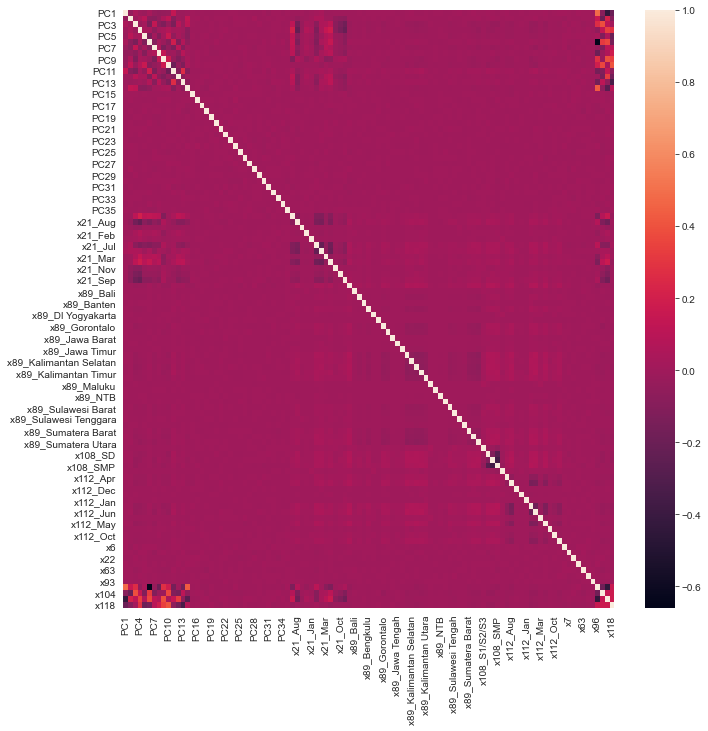

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(X_train_smenn.corr())

In [ ]:
X_train_smenn.columns.to_frame()

,0
PC1,PC1
PC2,PC2
PC3,PC3
PC4,PC4
PC5,PC5
PC6,PC6
PC7,PC7
PC8,PC8
PC9,PC9
PC10,PC10


In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(X_train_smenn, 0.7)
len(corr_features)

0

In [ ]:
X_train_smenn_m = X_train_smenn.drop(corr_features,axis=1)
X_test_m = X_test.drop(corr_features,axis=1)

### Chi-Square

In [ ]:
X_cat = X_train[categorical]
X_cat.head()

,x21,x79,x89,x108,x112
76513,Jun,Laki-laki,Kalimantan Utara,SMP,Jul
60406,Jun,Laki-laki,Sumatera Utara,SMA/SMK,Jul
27322,Jun,Laki-laki,Kalimantan Utara,SMP,May
53699,Jul,Laki-laki,Kalimantan Utara,SD,May
65412,Jul,Perempuan,Kalimantan Timur,SMA/SMK,Jul


In [ ]:
ordinal_label = {k: i for i, k in enumerate(X_cat['x89'].unique(), 0)}
X_cat['x89'] = X_cat['x89'].map(ordinal_label)

In [ ]:
for x in categorical:
    ordinal_label = {k: i for i, k in enumerate(X_cat[x].unique(), 0)}
    X_cat[x] = X_cat[x].map(ordinal_label)
X_cat.head()

,x21,x79,x89,x108,x112
76513,0,0,0,0,0
60406,0,0,1,1,0
27322,0,0,0,0,1
53699,1,0,0,2,1
65412,1,1,2,1,0


In [ ]:
from sklearn.feature_selection import chi2
f_p_values=chi2(X_cat,y_train)

In [ ]:
p_values=pd.Series(f_p_values[1])
p_values.index=X_cat.columns
p_values

x21     2.217238e-16
x79     8.261815e-01
x89     3.350911e-01
x108    6.244094e-01
x112    1.874501e-01
dtype: float64

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_selector = SelectKBest(chi2, k=2)
X_kbest = chi2_selector.fit_transform(X_cat,y_train)
print(X_kbest)

print('Original number of features:', X_cat.shape)
print('Reduced number of features:', X_kbest.shape)

[[0 0]
 [0 0]
 [0 1]
 ...
 [5 3]
 [3 3]
 [5 1]]
Original number of features: (70000, 5)
Reduced number of features: (70000, 2)


In [ ]:
X_kbest[:10]

array([[0, 0],
       [0, 0],
       [0, 1],
       [1, 1],
       [1, 0],
       [2, 0],
       [1, 1],
       [1, 2],
       [2, 2],
       [1, 1]], dtype=int64)

In [ ]:
nCol=np.arange(1,len(X_kbest[1,:])+1)
col = []
for x in nCol:
    col.append('chi'+str(x))

In [ ]:
X_chi = pd.DataFrame(data=X_kbest,columns=col)


In [ ]:
print(X_chi.shape,X_train.shape)
# type(X_train)

(70000, 2) (70000, 120)


pandas.core.frame.DataFrame

# Model and Evaluation

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

## With PCA, Oversampling and One-Hot Encoding

### XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_smenn, y_train_smenn)


[17:15:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred = xgb.predict(X_test)


Scikit-Learn's XGBoost's prediction accuracy is: 87.01
Scikit-Learn's XGBoost's prediction recall is: 0.47
Scikit-Learn's XGBoost's prediction FPR is: 0.05
Scikit-Learn's XGBoost's prediction Precision is: 0.68
Scikit-Learn's XGBoost's prediction auc_score is: 0.71
Scikit-Learn's XGBoost's prediction fnr is: 0.53
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     24823
           1       0.68      0.47      0.56      5177

    accuracy                           0.87     30000
   macro avg       0.79      0.71      0.74     30000
weighted avg       0.86      0.87      0.86     30000



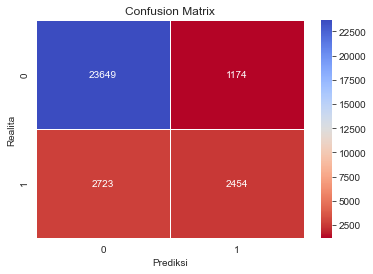

In [ ]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

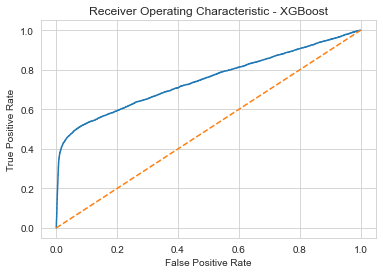

In [ ]:
y_score = xgb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_smenn, y_train_smenn)
y_pred = rfc.predict(X_test)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 80.70
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.34
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.10
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.43
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 0.62
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.66
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     24823
           1       0.43      0.34      0.38      5177

    accuracy                           0.81     30000
   macro avg       0.65      0.62      0.63     30000
weighted avg       0.79      0.81      0.80     30000



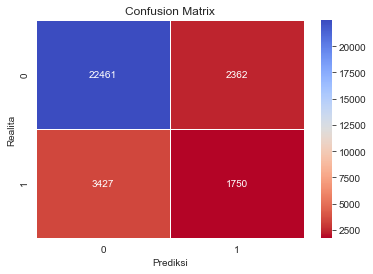

In [ ]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

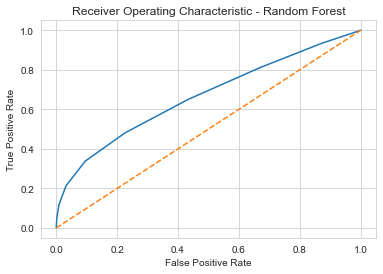

In [ ]:
y_score = rfc.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_smenn, y_train_smenn)
y_pred=logreg.predict(X_test)

Scikit-Learn's Logistic Regression's prediction accuracy is: 82.22
Scikit-Learn's Logistic Regression's prediction recall is: 0.26
Scikit-Learn's Logistic Regression's prediction FPR is: 0.06
Scikit-Learn's Logistic Regression's prediction Precision is: 0.47
Scikit-Learn's Logistic Regression's prediction auc_score is: 0.60
Scikit-Learn's Logistic Regression's prediction fnr is: 0.74
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     24823
           1       0.47      0.26      0.33      5177

    accuracy                           0.82     30000
   macro avg       0.67      0.60      0.61     30000
weighted avg       0.79      0.82      0.80     30000



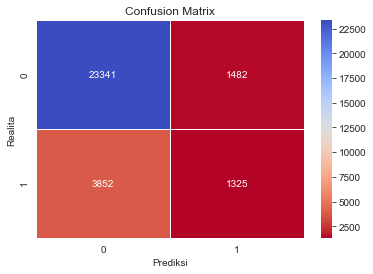

In [ ]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Logistic Regression's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Logistic Regression's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Logistic Regression's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's Logistic Regression's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's Logistic Regression's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's Logistic Regression's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

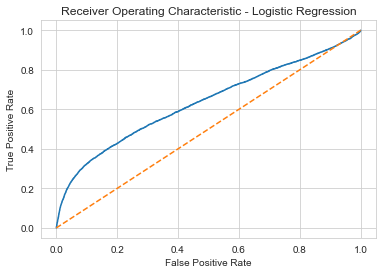

In [ ]:
y_score = logreg.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

### LightGBM

In [ ]:
# !pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train_smenn, y_train_smenn)
y_pred = lgb.predict(X_test)

Scikit-Learn's LightGBM's prediction accuracy is: 87.92
Scikit-Learn's LightGBM's prediction recall is: 0.45
Scikit-Learn's LightGBM's prediction FPR is: 0.03
Scikit-Learn's LightGBM's prediction Precision is: 0.75
Scikit-Learn's LightGBM's prediction auc_score is: 0.71
Scikit-Learn's LightGBM's prediction fnr is: 0.55
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     24823
           1       0.75      0.45      0.56      5177

    accuracy                           0.88     30000
   macro avg       0.82      0.71      0.75     30000
weighted avg       0.87      0.88      0.87     30000



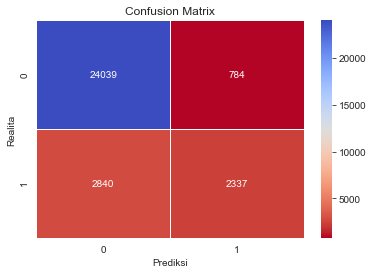

In [ ]:
acc_lgbm = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_lgbm = recall_score(y_test, y_pred)
tnr_lgbm = recall_score(y_test, y_pred, pos_label = 0)
fpr_lgbm = 1 - tnr_lgbm
prec_lgbm = precision_score(y_test, y_pred)
auc_lgbm = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's LightGBM's prediction accuracy is: %3.2f" % (acc_lgbm))
print("Scikit-Learn's LightGBM's prediction recall is: %3.2f" % (recall_lgbm))
print("Scikit-Learn's LightGBM's prediction FPR is: %3.2f" % (fpr_lgbm))
print("Scikit-Learn's LightGBM's prediction Precision is: %3.2f" % (prec_lgbm))
print("Scikit-Learn's LightGBM's prediction auc_score is: %3.2f" % (auc_lgbm))
print("Scikit-Learn's LightGBM's prediction fnr is: %3.2f" % (1-recall_lgbm))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-lgbm.png')

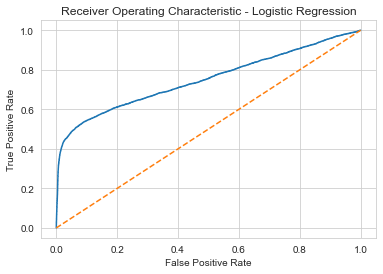

In [ ]:
y_score = lgb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [ ]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression', 'LightGBM'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg,recall_lgbm],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg,fpr_lgbm],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg,acc_lgbm],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg,prec_lgbm],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg,auc_lgbm],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg, 1-recall_lgbm]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
XGBoost,0.474020,0.047295,87.010000,0.676406,0.713362,0.525980
LightGBM,0.451420,0.031584,87.920000,0.748798,0.709918,0.548580
Random Forest,0.338034,0.095154,80.703333,0.425584,0.621440,0.661966
Logistic Regression,0.255940,0.059703,82.220000,0.472034,0.598119,0.744060


### Tuning Hyperparameter (GridSearchCV)

In [ ]:
from sklearn.model_selection import GridSearchCV
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgb = XGBClassifier(seed = 20)
clf = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train_smenn, y_train_smenn)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[09:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:50:1

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(**clf.best_params_)
xgb.fit(X_train_smenn, y_train_smenn)

y_pred = xgb.predict(X_test)

[16:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Scikit-Learn's XGBoost's prediction accuracy is: 87.96
Scikit-Learn's XGBoost's prediction recall is: 0.40
Scikit-Learn's XGBoost's prediction FPR is: 0.02
Scikit-Learn's XGBoost's prediction Precision is: 0.81
Scikit-Learn's XGBoost's prediction auc_score is: 0.69
Scikit-Learn's XGBoost's prediction fnr is: 0.60
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     24823
           1       0.81      0.40      0.53      5177

    accuracy                           0.88     30000
   macro avg       0.85      0.69      0.73     30000
weighted avg       0.87      0.88      0.86     30000



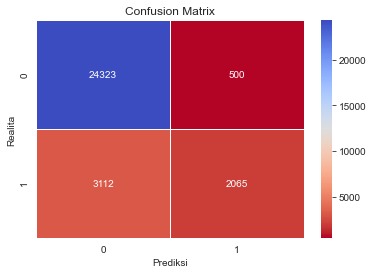

In [ ]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

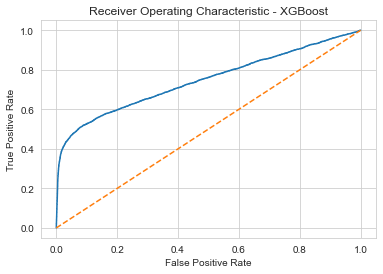

In [ ]:
y_score = xgb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

## With VIF and Oversampling

### XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_v, y_train_smenn)


[14:02:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred = xgb.predict(X_test_v)


Scikit-Learn's XGBoost's prediction accuracy is: 87.88
Scikit-Learn's XGBoost's prediction recall is: 0.36
Scikit-Learn's XGBoost's prediction FPR is: 0.01
Scikit-Learn's XGBoost's prediction Precision is: 0.85
Scikit-Learn's XGBoost's prediction auc_score is: 0.67
Scikit-Learn's XGBoost's prediction fnr is: 0.64
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     24823
           1       0.85      0.36      0.51      5177

    accuracy                           0.88     30000
   macro avg       0.86      0.67      0.72     30000
weighted avg       0.88      0.88      0.86     30000



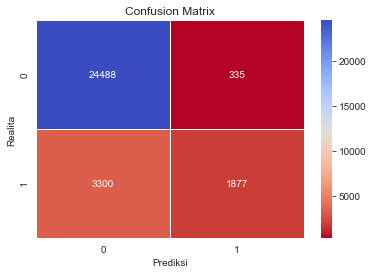

In [ ]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

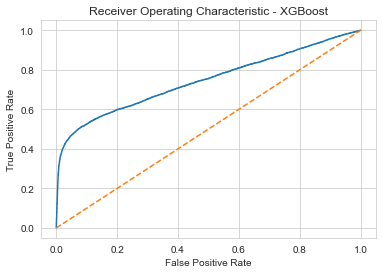

In [ ]:
y_score = xgb.predict_proba(X_test_v)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_v, y_train_smenn)
y_pred = rfc.predict(X_test_v)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 84.01
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.18
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.02
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.63
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 0.58
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.82
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     24823
           1       0.63      0.18      0.28      5177

    accuracy                           0.84     30000
   macro avg       0.74      0.58      0.59     30000
weighted avg       0.81      0.84      0.80     30000



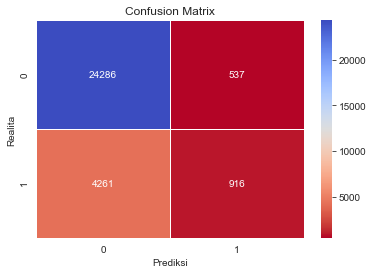

In [ ]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

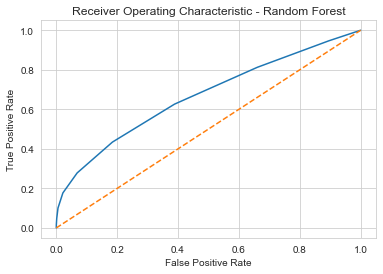

In [ ]:
y_score = rfc.predict_proba(X_test_v)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_v, y_train_smenn)
y_pred=logreg.predict(X_test_v)

Scikit-Learn's Logistic Regression's prediction accuracy is: 83.82
Scikit-Learn's Logistic Regression's prediction recall is: 0.10
Scikit-Learn's Logistic Regression's prediction FPR is: 0.01
Scikit-Learn's Logistic Regression's prediction Precision is: 0.72
Scikit-Learn's Logistic Regression's prediction auc_score is: 0.55
Scikit-Learn's Logistic Regression's prediction fnr is: 0.90
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     24823
           1       0.72      0.10      0.18      5177

    accuracy                           0.84     30000
   macro avg       0.78      0.55      0.54     30000
weighted avg       0.82      0.84      0.78     30000



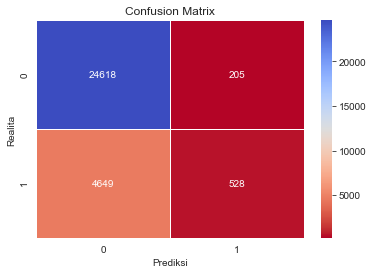

In [ ]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Logistic Regression's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Logistic Regression's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Logistic Regression's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's Logistic Regression's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's Logistic Regression's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's Logistic Regression's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

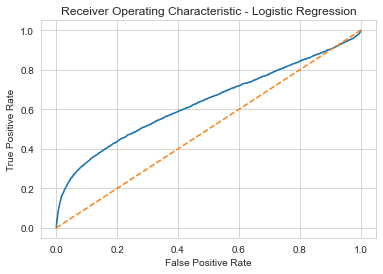

In [ ]:
y_score = logreg.predict_proba(X_test_v)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [ ]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
XGBoost,0.362565,0.013496,87.883333,0.848553,0.674535,0.637435
Random Forest,0.176936,0.021633,84.006667,0.630420,0.577652,0.823064
Logistic Regression,0.101990,0.008258,83.820000,0.720327,0.546866,0.898010


## ANN

In [ ]:
#!pip install tensorflow

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached rsa-4.8-py3-none-any.whl (39 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=1b842e4f711effc0d03c7dc171710bd17daae8edf64c39086295aecac86741e

In [ ]:
import tensorflow as tf


In [ ]:
ann = tf.keras.models.Sequential()


In [ ]:
ann.add(tf.keras.layers.Dense(units=177,activation="relu"))


In [ ]:
ann.add(tf.keras.layers.Dense(units=177,activation="relu"))


In [ ]:
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))


In [ ]:
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])


In [ ]:
ann.fit(X_train,y_train,batch_size=32,epochs = 100)


Epoch 1/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.4330 - accuracy: 0.8677
Epoch 2/100
2188/2188 [==============================] - 5s 2ms/step - loss: 0.3386 - accuracy: 0.8950
Epoch 3/100
2188/2188 [==============================] - 2s 1ms/step - loss: 0.3270 - accuracy: 0.8990
Epoch 4/100
2188/2188 [==============================] - 2s 1ms/step - loss: 0.3207 - accuracy: 0.9014
Epoch 5/100
2188/2188 [==============================] - 2s 1ms/step - loss: 0.3150 - accuracy: 0.9029
Epoch 6/100
2188/2188 [==============================] - 2s 985us/step - loss: 0.3100 - accuracy: 0.9047
Epoch 7/100
2188/2188 [==============================] - 3s 1ms/step - loss: 0.3050 - accuracy: 0.9059
Epoch 8/100
2188/2188 [==============================] - 2s 1ms/step - loss: 0.3007 - accuracy: 0.9070
Epoch 9/100
2188/2188 [==============================] - 2s 1ms/step - loss: 0.2963 - accuracy: 0.9081
Epoch 10/100
2188/2188 [==============================] - 2s 1ms/step -

In [ ]:
y_pred = ann.predict(X_test)


In [ ]:
y_pred = np.where(y_pred > 0.5,1,0)

In [ ]:
y_pred = y_pred.ravel()

In [ ]:
y_pred[:10]

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [ ]:
y_pred.shape

(30000,)

Scikit-Learn's XGBoost's prediction accuracy is: 84.72
Scikit-Learn's XGBoost's prediction recall is: 0.49
Scikit-Learn's XGBoost's prediction FPR is: 0.08
Scikit-Learn's XGBoost's prediction Precision is: 0.57
Scikit-Learn's XGBoost's prediction auc_score is: 0.71
Scikit-Learn's XGBoost's prediction fnr is: 0.51
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     24823
           1       0.57      0.49      0.53      5177

    accuracy                           0.85     30000
   macro avg       0.73      0.71      0.72     30000
weighted avg       0.84      0.85      0.84     30000



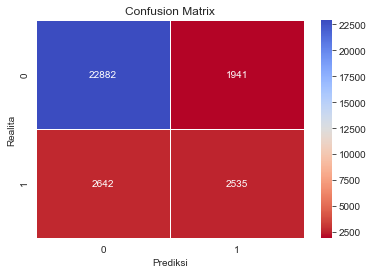

In [ ]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

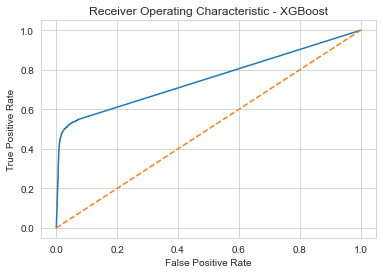

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

## with Chi-squared Selection and PCA